# KE5018 Time Series Forecasting

## Load libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

## Load time series data

In [2]:
ts_df = pd.read_excel('data/ActualRatings_weeklyGRP.xls', sheet_name=1)

In [3]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
GRPRatingsDate    92 non-null object
GRP               92 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [4]:
ts_df.head()

,GRPRatingsDate,GRP
0,17-Jun-2007 (25),243.60
1,24-Jun-2007 (26),263.19
2,01-Jul-2007 (27),269.89
3,08-Jul-2007 (28),252.88
4,15-Jul-2007 (29),303.46


In [5]:
ts_df.tail()

,GRPRatingsDate,GRP
87,15-Feb-2009 (8),204.20
88,22-Feb-2009 (9),200.61
89,01-Mar-2009 (10),208.56
90,08-Mar-2009 (11),191.74
91,15-Mar-2009 (12),222.07


## Transform the Data for Analysis

In [6]:
# Create a date/time column for week.
ts_df['weekly_date'] = pd.date_range('17/6/2007', '15/3/2009', freq='W')

In [7]:
ts_df.head()

,GRPRatingsDate,GRP,weekly_date
0,17-Jun-2007 (25),243.60,2007-06-17
1,24-Jun-2007 (26),263.19,2007-06-24
2,01-Jul-2007 (27),269.89,2007-07-01
3,08-Jul-2007 (28),252.88,2007-07-08
4,15-Jul-2007 (29),303.46,2007-07-15


In [8]:
# Index the data frame by week. Keep the original index as a running number by week. 
ts_df.reset_index(inplace=True)
ts_df.set_index('weekly_date', inplace=True)

In [9]:
ts_df.head()

,index,GRPRatingsDate,GRP
weekly_date,,,
2007-06-17,0,17-Jun-2007 (25),243.60
2007-06-24,1,24-Jun-2007 (26),263.19
2007-07-01,2,01-Jul-2007 (27),269.89
2007-07-08,3,08-Jul-2007 (28),252.88
2007-07-15,4,15-Jul-2007 (29),303.46


In [10]:
ts_df.rename(columns={'index':'week'}, inplace=True)

In [11]:
ts_df.describe()

,week,GRP
count,92.00000,92.000000
mean,45.50000,240.829783
std,26.70206,38.680913
min,0.00000,170.740000
25%,22.75000,209.980000
50%,45.50000,231.490000
75%,68.25000,272.927500
max,91.00000,327.220000


In [12]:
# Save the data frame to file.
ts_df.to_csv('data/transformedRatings.csv')

## Show the Time Series Data

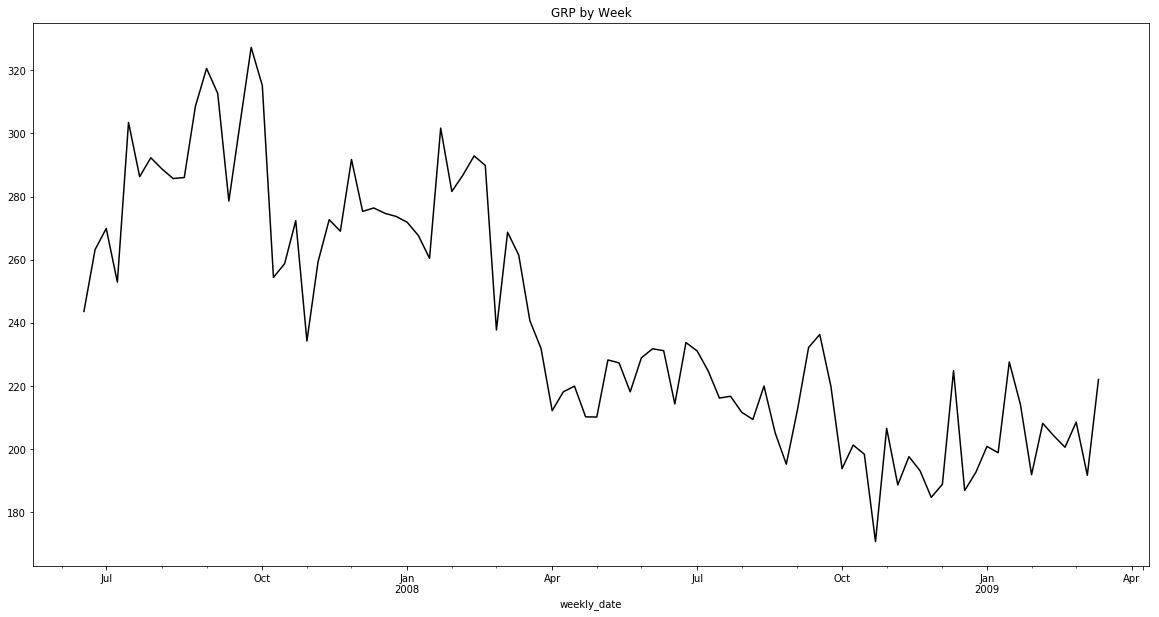

In [13]:
ts_df['GRP'].plot(figsize=(20, 10), title='GRP by Week', color='black')

## Prepare the Train / Test Datasets

In [14]:
train_ts_df = ts_df.loc['17/6/2007':'17/6/2008']
test_ts_df = ts_df.loc['18/6/2008':]

In [15]:
train_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2007-06-17 to 2008-06-15
Data columns (total 3 columns):
week              53 non-null int64
GRPRatingsDate    53 non-null object
GRP               53 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ KB


In [16]:
test_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2008-06-22 to 2009-03-15
Data columns (total 3 columns):
week              39 non-null int64
GRPRatingsDate    39 non-null object
GRP               39 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ KB


In [17]:
train_ts_df['GRP'].values

array([ 243.6 ,  263.19,  269.89,  252.88,  303.46,  286.29,  292.28,
        288.72,  285.7 ,  286.01,  308.59,  320.57,  312.67,  278.58,
        303.06,  327.22,  315.14,  254.39,  258.73,  272.35,  234.26,
        259.35,  272.67,  269.03,  291.72,  275.29,  276.38,  274.68,
        273.7 ,  271.84,  267.63,  260.45,  301.67,  281.6 ,  286.82,
        292.87,  289.84,  237.74,  268.69,  261.46,  240.68,  231.89,
        212.18,  218.16,  219.96,  210.24,  210.17,  228.25,  227.32,
        218.16,  228.92,  231.79,  231.19])

## Linear Regression Model

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
lin_reg_train_pred = lin_reg.predict(train_ts_df['week'].values.reshape(-1, 1))
lin_reg_train_pred[:10]

array([ 299.22079665,  297.92995323,  296.63910982,  295.34826641,
        294.057423  ,  292.76657958,  291.47573617,  290.18489276,
        288.89404935,  287.60320593])

In [20]:
lin_reg_train_mse = mean_squared_error(train_ts_df['GRP'].values, lin_reg_train_pred)
lin_reg_train_mse

552.06928509400495

In [21]:
lin_reg_train_rmse = np.sqrt(lin_reg_train_mse)
lin_reg_train_rmse

23.496154687395233

In [22]:
lin_reg_r2 = r2_score(train_ts_df['GRP'].values, lin_reg_train_pred)
#lin_reg_r2 = lin_reg.score(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP'].values)
lin_reg_r2

0.41392552296433993

In [23]:
lin_reg_test_pred = lin_reg.predict(test_ts_df['week'].values.reshape(-1, 1))
lin_reg_test_pred[:10]

array([ 230.80609579,  229.51525238,  228.22440897,  226.93356555,
        225.64272214,  224.35187873,  223.06103532,  221.7701919 ,
        220.47934849,  219.18850508])

In [24]:
lin_reg_test_mse = mean_squared_error(test_ts_df['GRP'].values, lin_reg_test_pred)
lin_reg_test_rmse = np.sqrt(lin_reg_test_mse)
lin_reg_test_rmse

16.661041078120078

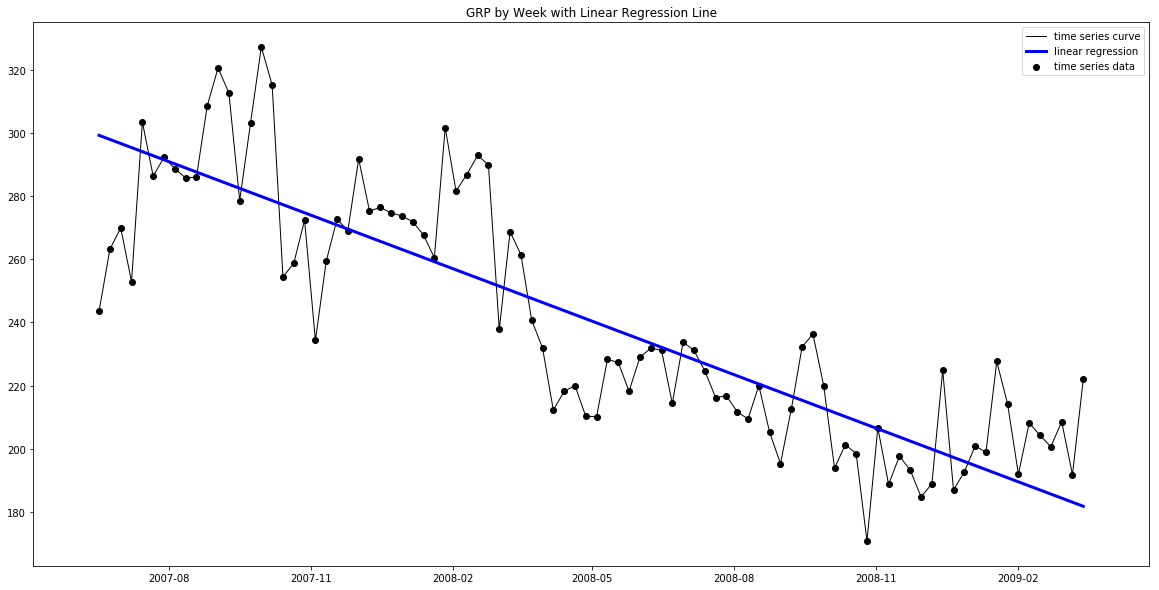

In [25]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Linear Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([lin_reg_train_pred, lin_reg_test_pred]), color='blue', linewidth=3, label='linear regression')
plt.legend()
plt.show()

In [26]:
#train_ts_df['residuals'] = train_ts_df['GRP'].values - lin_reg_train_pred
residuals = train_ts_df['GRP'].values - lin_reg_train_pred
residuals

array([-55.62079665, -34.73995323, -26.74910982, -42.46826641,
         9.402577  ,  -6.47657958,   0.80426383,  -1.46489276,
        -3.19404935,  -1.59320593,  22.27763748,  35.54848089,
        28.9393243 ,  -3.85983229,  21.91101113,  47.36185454,
        36.57269795, -22.88645864, -17.25561522,  -2.34477181,
       -39.1439284 , -12.76308499,   1.84775843,  -0.50139816,
        23.47944525,   8.34028866,  10.72113208,  10.31197549,
        10.6228189 ,  10.05366231,   7.13450572,   1.24534914,
        43.75619255,  24.97703596,  31.48787937,  38.82872279,
        37.0895662 , -13.71959039,  18.52125302,  12.58209644,
        -6.90706015, -14.40621674, -32.82537333, -25.55452991,
       -22.4636865 , -30.89284309, -29.67199968, -10.30115627,
        -9.94031285, -17.80946944,  -5.75862603,  -1.59778262,  -0.9069392 ])

In [27]:
poly_reg_res = Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression(fit_intercept=False))])
poly_reg_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
poly_reg_res_pred = poly_reg_res.predict(train_ts_df['week'].values.reshape(-1, 1))

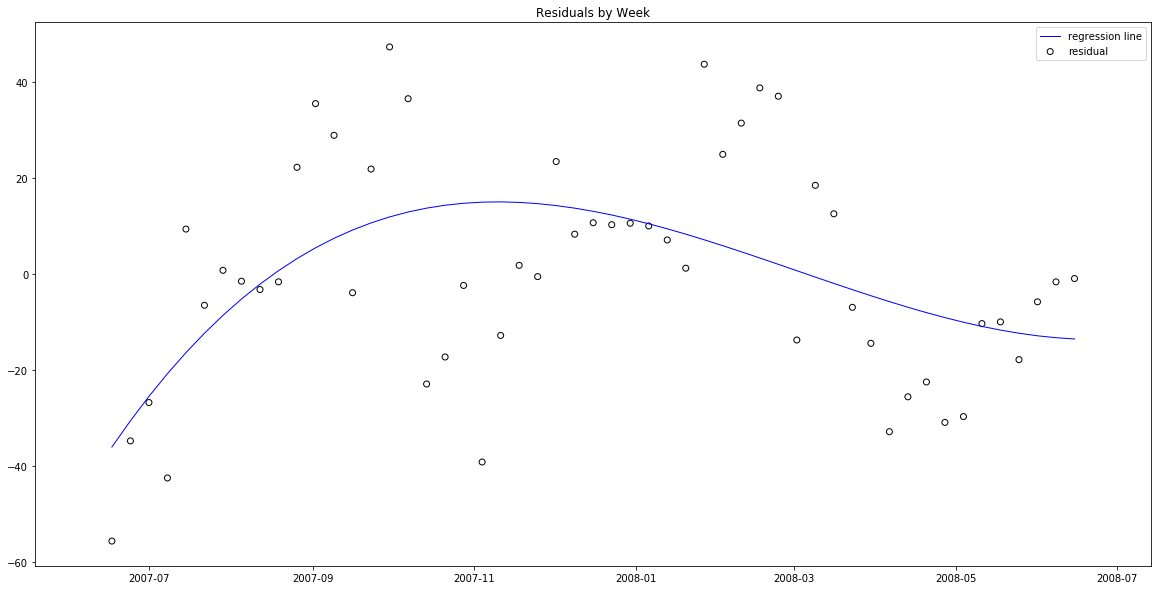

In [28]:
plt.figure(figsize=(20, 10))
plt.title('Residuals by Week')
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residual', facecolors='none')
plt.plot(train_ts_df.index.values, poly_reg_res_pred, color='blue', linewidth=1, label='regression line')
plt.legend()
plt.show()

The residuals are not white noise. The linear model is not a suitable functional form for the time series data.

## Polynomial Regression Model

In [28]:
poly_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression(fit_intercept=False))])
poly_reg.fit(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP'])
poly_reg_train_pred = poly_reg.predict(train_ts_df['week'].values.reshape(-1, 1))

In [30]:
poly_reg_train_mse = mean_squared_error(train_ts_df['GRP'].values, poly_reg_train_pred)
poly_reg_train_rmse = np.sqrt(poly_reg_train_mse)
poly_reg_train_rmse

19.800976607456217

In [31]:
poly_reg_r2 = r2_score(train_ts_df['GRP'].values, poly_reg_train_pred)
poly_reg_r2

0.58377089546071503

In [32]:
poly_reg_test_pred = poly_reg.predict(test_ts_df['week'].values.reshape(-1, 1))
poly_reg_test_mse = mean_squared_error(test_ts_df['GRP'].values, poly_reg_test_pred)
poly_reg_test_rmse = np.sqrt(poly_reg_test_mse)
poly_reg_test_rmse

73.019110785803605

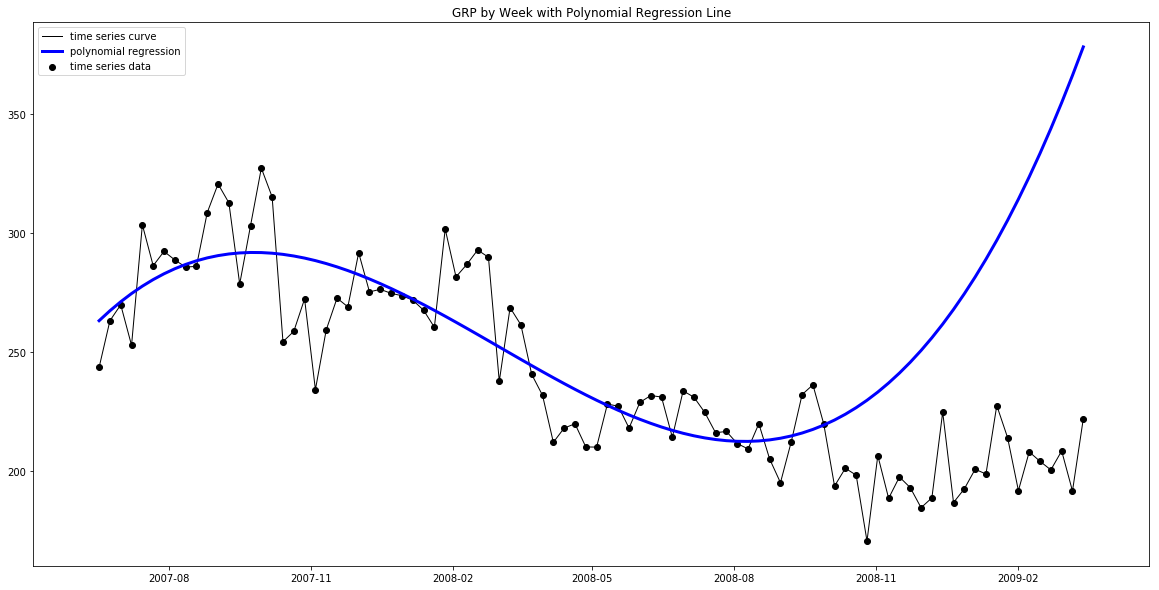

In [33]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Polynomial Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([poly_reg_train_pred, poly_reg_test_pred]), color='blue', linewidth=3, label='polynomial regression')
plt.legend()
plt.show()

The polynomial regression model generalises poorly to the test data. Higher degree polynomial models perform worse.